<a href="https://colab.research.google.com/github/pruthvip98/first-repo/blob/master/Capsule_Network_CopyMoveTampering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

from keras.models import Sequential
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import cv2
import numpy as np
from PIL import Image
from sklearn.feature_extraction import image
import keras.preprocessing.image
import matplotlib.pyplot as plt
from keras.layers import Input, MaxPool2D, Flatten, Dense
from keras.models import Model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My Drive/DA Project

/content/drive/My Drive/DA Project


In [0]:
X = np.load('FinalBatch/Batch0.npy')
y = np.load('FinalBatch/Output0.npy')
print(np.shape(y))
for i in range(1, 50):
  X = np.concatenate((X, np.load('FinalBatch/Batch'+str(i)+'.npy') ))
  print(np.shape(X))
for i in range(1, 50):
  y = np.concatenate((y, np.load('FinalBatch/Output'+str(i)+'.npy')))
  print(np.shape(y))


#X = np.concatenate((X1, X2), 0)
#print(np.shape(X))


(6488, 1)
(15246, 32, 32, 2)
(19890, 32, 32, 2)
(27092, 32, 32, 2)
(36454, 32, 32, 2)
(44080, 32, 32, 2)
(49052, 32, 32, 2)
(58298, 32, 32, 2)
(66610, 32, 32, 2)
(75772, 32, 32, 2)
(84518, 32, 32, 2)
(96374, 32, 32, 2)
(102316, 32, 32, 2)
(107900, 32, 32, 2)
(111558, 32, 32, 2)
(115224, 32, 32, 2)
(119138, 32, 32, 2)
(122288, 32, 32, 2)
(127902, 32, 32, 2)
(134836, 32, 32, 2)
(140576, 32, 32, 2)
(144432, 32, 32, 2)
(148220, 32, 32, 2)
(152554, 32, 32, 2)
(158622, 32, 32, 2)
(162876, 32, 32, 2)
(166636, 32, 32, 2)
(171668, 32, 32, 2)
(177798, 32, 32, 2)
(184328, 32, 32, 2)
(187842, 32, 32, 2)
(192118, 32, 32, 2)
(196680, 32, 32, 2)
(199622, 32, 32, 2)
(202414, 32, 32, 2)
(208466, 32, 32, 2)
(211280, 32, 32, 2)
(213688, 32, 32, 2)
(216390, 32, 32, 2)
(220932, 32, 32, 2)
(225864, 32, 32, 2)
(230386, 32, 32, 2)


In [0]:
#X = X / 255.0
input_shape = Input(shape=(32,32,2))  # size of input image is 28*28
 
# a convolution layer output shape = 20*20*256
conv1 = Conv2D(32, (3,3), activation = 'relu')(input_shape)
conv2 = Conv2D(32, (3,3))(conv1)
 
# reshape into 1152 capsules of 8 dimensional vectors
reshaped = keras.layers.Reshape((28*28*4,8))(conv2)
 
  
def squash(inputs):
    # take norm of input vectors
    squared_norm = K.sum(K.square(inputs), axis = -1, keepdims = True)
 
    # use the formula for non-linear function to return squashed output
    return ((squared_norm/(1+squared_norm))/(K.sqrt(squared_norm+K.epsilon())))*inputs
# squash the reshaped output to make length of vector b/w 0 and 1
squashed_output = keras.layers.Lambda(squash)(reshaped)
squashed_output.shape

class DigitCapsuleLayer(keras.layers.Layer):
    # creating a layer class in keras
    def __init__(self, **kwargs):
        super(DigitCapsuleLayer, self).__init__(**kwargs)
        self.kernel_initializer = keras.initializers.get('glorot_uniform')
    
    def build(self, input_shape): 
        # initialize weight matrix for each capsule in lower layer
        self.W = self.add_weight(shape = [2, 28*28*4, 16, 8], initializer = self.kernel_initializer, name = 'weights')
        self.built = True
    
    def call(self, inputs):
        inputs = K.expand_dims(inputs, 1)
        inputs = K.tile(inputs, [1, 2, 1, 1])
        # matrix multiplication b/w previous layer output and weight matrix
        inputs = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs)
        b = tf.zeros(shape = [K.shape(inputs)[0], 2, 28*28*4])
        
# routing algorithm with updating coupling coefficient c, using scalar product b/w input capsule and output capsule
        for i in range(3-1):
            c = tf.nn.softmax(b, dim=1)
            s = K.batch_dot(c, inputs, [2, 2])
            v = squash(s)
            b = b + K.batch_dot(v, inputs, [2,3])
            
        return v 
    def compute_output_shape(self, input_shape):
        return tuple([None, 2, 16])
 
def output_layer(inputs):
    return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())
 
digit_caps = DigitCapsuleLayer()(squashed_output)
outputs = keras.layers.Lambda(output_layer)(digit_caps)
outputs.shape

from keras.layers import Flatten, Reshape,Dense,Lambda
def mask(outputs):

    if type(outputs) != list:  # mask at test time
        norm_outputs = K.sqrt(K.sum(K.square(outputs), -1) + K.epsilon())
        y  = K.one_hot(indices=K.argmax(norm_outputs, 1), num_classes = 2)
        y = Reshape((2,1))(y)
        return Flatten()(y*outputs)

    else:    # mask at train time
        y = Reshape((2,1))(outputs[1])
        masked_output = y*outputs[0]
        return keras.layers.Flatten()(masked_output)

inputs = keras.layers.Input(shape = (2,))
masked = keras.layers.Lambda(mask)([digit_caps, inputs])
masked_for_test = Lambda(mask)(digit_caps)

decoded_inputs = Input(shape = (16*2,))
dense1 = Dense(512, activation = 'relu')(decoded_inputs)
dense2 = Dense(1024, activation = 'relu')(dense1)
decoded_outputs = Dense(2048, activation = 'sigmoid')(dense2)
decoded_outputs = keras.layers.Reshape((32,32,2))(decoded_outputs)

def loss_fn(y_true, y_pred):

    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))
  
decoder = Model(decoded_inputs, decoded_outputs)
model = Model([input_shape,inputs],[outputs,decoder(masked)])
test_model = Model(input_shape,[outputs,decoder(masked_for_test)])

m = 128
epochs = 10
from keras.callbacks import ModelCheckpoint
sgd = keras.optimizers.RMSprop(lr=0.001, rho=0.90, epsilon=None, decay=0.0)
filepath="weights.best.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_model_1_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
model.load_weights("weights.best.hdf5")
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


W0627 10:33:15.830333 139744095020928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 10:33:15.876224 139744095020928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 10:33:15.884393 139744095020928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 10:33:16.049721 139744095020928 deprecation.py:506] From <ipython-input-4-318e1d4702ca>:41: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead
W0627 1

In [0]:
p = 255892
from keras.utils import to_categorical 
#y = to_categorical(y)
#y.shape

In [0]:
#model.fit([X[0:p], y[0:p]],[y[0:p],X[0:p]], batch_size = m, epochs = epochs ,callbacks=[checkpoint],validation_split = 0.2)

W0619 19:35:38.761925 140050773538688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0619 19:35:39.315839 140050773538688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 204713 samples, validate on 51179 samples
Epoch 1/10
204713/204713 [==============================] - 345s 2ms/step - loss: 1.3191 - lambda_2_loss: 0.6361 - model_1_loss: 0.6830 - lambda_2_acc: 0.6192 - model_1_acc: 0.7566 - val_loss: 1.3449 - val_lambda_2_loss: 0.6705 - val_model_1_loss: 0.6744 - val_lambda_2_acc: 0.6195 - val_model_1_acc: 0.8374

Epoch 00001: val_model_1_acc improved from -inf to 0.83742, saving model to weights.best.hdf5
Epoch 2/10
204713/204713 [==============================] - 336s 2ms/step - loss: 1.2725 - lambda_2_loss: 0.5916 - model_1_loss: 0.6809 - lambda_2_acc: 0.6885 - model_1_acc: 0.8413 - val_loss: 1.3297 - val_lambda_2_loss: 0.6557 - val_model_1_loss: 0.6740 - val_lambda_2_acc: 0.6235 - val_model_1_acc: 0.8074

Epoch 00002: val_model_1_acc did not improve from 0.83742
Epoch 3/10
204713/204713 [==============================] - 336s 2ms/step - loss: 1.2656 - lambda_2_loss: 0.5848 - model_1_loss: 0.6808 - lambda_2_acc: 0.6933 - model_1_acc: 0.840

In [0]:
p = 255892
model.evaluate([X[p:],y[p:]],[y[p:],X[p:]],batch_size=128)

10000/10000 [==============================] - 18s 2ms/step


[1.2689613540649414,
 0.5913898995399475,
 0.6775714546203613,
 0.688,
 0.85395859375]

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 32)   608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3136, 8)      0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
lambda_1 (

In [0]:
from os import listdir
from os.path import isfile, join
mypath = '50'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = np.sort(onlyfiles)
onlyfiles

array(['Tp_D_CND_S_N_txt00028_txt00006_10848.jpg',
       'Tp_D_CND_S_N_txt00028_txt00006_10848_gt.png',
       'Tp_D_CNN_M_B_nat10139_nat00059_11949.jpg',
       'Tp_D_CNN_M_B_nat10139_nat00059_11949_gt.png',
       'Tp_D_CNN_M_N_sec10107_sec10101_10299.tif',
       'Tp_D_CNN_M_N_sec10107_sec10101_10299_gt.png',
       'Tp_D_CNN_M_N_sec10110_sec10101_10298.tif',
       'Tp_D_CNN_M_N_sec10110_sec10101_10298_gt.png',
       'Tp_D_CNN_S_N_ani00087_ani00088_10102.tif',
       'Tp_D_CNN_S_N_ani00087_ani00088_10102_gt.png',
       'Tp_D_CRD_S_N_sec00037_art00028_00058.tif',
       'Tp_D_CRD_S_N_sec00037_art00028_00058_gt.png',
       'Tp_D_CRN_M_B_ani00046_ani00001_10100.tif',
       'Tp_D_CRN_M_B_ani00046_ani00001_10100_gt.png',
       'Tp_D_CRN_S_O_ani10103_ani10111_10636.jpg',
       'Tp_D_CRN_S_O_ani10103_ani10111_10636_gt.png',
       'Tp_D_NND_L_B_arc00072_nat00097_00292.tif',
       'Tp_D_NND_L_B_arc00072_nat00097_00292_gt.png',
       'Tp_D_NND_M_B_cha00094_cha00095_11445.jpg',
    

In [0]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
from PIL import Image
from skimage.util import view_as_windows
from skimage.color import rgb2ycbcr
col = Image.open("50/"+onlyfiles[1])
#gray = col.convert('L')
#bw = gray.point(lambda x: 0 if x<128 else 255, '1')
img = np.array(col,dtype='float32')
bnimg = np.dot(img[1,1,:], [0.299, 0.587, 0.114])/255
sumimg = np.sum(bnimg/(32*32))
print(sumimg)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[1].imshow(bnimg)
plt.show()

NameError: ignored

In [0]:

for i in range(0,50):
  print(i)
  img = np.array(Image.open("50/"+onlyfiles[2*i]),dtype='float32')
  print(img.dtype)
  patches = view_as_windows(img,[32,32,3],1)
  patches = patches.reshape((patches.shape[0]*patches.shape[1],32,32,3))

  img = np.array(Image.open("50/"+onlyfiles[2*i+1]))
  patchesGT = view_as_windows(img,[32,32,3],1)
  patchesGT = patchesGT.reshape((patchesGT.shape[0]*patchesGT.shape[1],32,32,3))
  #print(patches[342,:,:,1:3])

  #crcbPatches = []
  output=[]
  for j in range(0,patches.shape[0]):
    patches[j][:,:,1:3] = rgb2ycbcr(patches[j])[:,:,1:3]
    #crcbPatches.append(inpPT)
    if(.35<np.sum(np.dot(patchesGT[j][:,:,:], [0.299, 0.587, 0.114])/255)/(32*32) 
       and .65>np.sum(np.dot(patchesGT[j][:,:,:], [0.299, 0.587, 0.114])/255)/(32*32)):
        output.append(1)
    else:
        output.append(0)
  print(patches.dtype)
  #crcbPatches = np.array(crcbPatches)
  output = np.array(output)
  #print(patches[342,:,:,1:3])
  patches[:,:,:,1:3] = patches[:,:,:,1:3] / 255.0
  #print(patches[:,:,:,1:3])
  output = to_categorical(output)
  finalOutput=model.predict([patches[:,:,:,1:3],output],batch_size=128)[0]
  #print(finalOutput)
  zerosOnes = []
  for k in range(finalOutput.shape[0]):
    if(finalOutput[k,1]>finalOutput[k,0]):
      zerosOnes.append(1)
    else:
      zerosOnes.append(0)
  zerosOnes = np.array(zerosOnes)
  #print(np.argwhere(zerosOnes!=0))
  r = img.shape[0] - 31
  c = img.shape[1] - 31
  zerosOnes = zerosOnes.reshape((r,c))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(zerosOnes)
  axarr[1].imshow(img)
  plt.show()

0
float32


KeyboardInterrupt: ignored

In [0]:
 finalOutput

array([[0.00539505, 0.00156307],
       [0.00540467, 0.00156685],
       [0.00540939, 0.00158315],
       [0.00541743, 0.00161815],
       [0.00544934, 0.00164338],
       [0.00548301, 0.00165729],
       [0.00552261, 0.00167092],
       [0.00553702, 0.00169128],
       [0.00554164, 0.00171394],
       [0.00552889, 0.00173704],
       [0.00552319, 0.00175397],
       [0.00553605, 0.00176624],
       [0.00554952, 0.00177737],
       [0.00555263, 0.00178486],
       [0.00556179, 0.00178387],
       [0.00554967, 0.00178325],
       [0.00553595, 0.0017812 ],
       [0.00552003, 0.00177698],
       [0.00551528, 0.00177106],
       [0.00549684, 0.00177746],
       [0.00548567, 0.00179391],
       [0.00548657, 0.0018204 ],
       [0.00548187, 0.00184633],
       [0.0054705 , 0.00186123],
       [0.00547652, 0.00186196],
       [0.00548685, 0.00185346],
       [0.00548991, 0.00185336],
       [0.00547342, 0.00187763],
       [0.00547215, 0.00192073],
       [0.00548093, 0.00195971],
       [0.

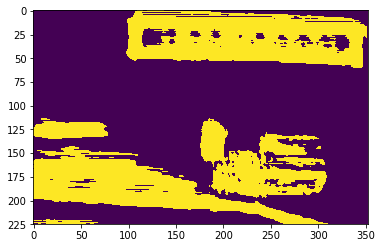

In [0]:
zerosOnes = []
for i in range(finalOutput.shape[0]):
  if(finalOutput[i,1]>finalOutput[i,0]):
    zerosOnes.append(1)
  else:
    zerosOnes.append(0)
zerosOnes = np.array(zerosOnes)
zerosOnes = zerosOnes.reshape((225,353))
plt.imshow(zerosOnes)

In [0]:
patches[[k[i,0] for i in range(k.shape[0])]] = 255.0
patches[[l[i,0] for i in range(l.shape[0])]] = 0.0
imgT = np.zeros((256,384))
r = ((imgT.shape[0] - 32)//1) + 1
c = ((imgT.shape[1] - 32)//1) + 1
for i in range(k.shape[0]):
  col = int(k[i])%c
  row = int(k[i])//r
  imgT[row:row+32,col:col+32] = 255
finalOutput.shape

(828, 2)

In [0]:
model.evaluate([crcbPatches,output],[output,crcbPatches],batch_size=128)

79425/79425 [==============================] - 119s 2ms/step


[1.3500665668124932,
 0.6435041461765372,
 0.7065624199635508,
 0.6537362291642544,
 0.7940512374237644]

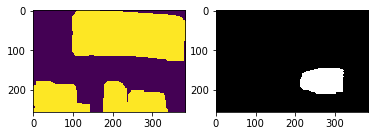

In [0]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(imgT)
axarr[1].imshow(img)